# REB-1 Analysis
Compute Wh per run, convert to g CO₂, overlay `/cmd_vel` on watts, and export bar chart + GIF.

In [29]:

import pandas as pd, numpy as np, matplotlib.pyplot as plt, imageio, os
DATA_IDLE = os.path.join('data','sample','demo_idle_60s.csv')
DATA_WORK = os.path.join('data','sample','demo_work_60s.csv')
DATA_GPU = os.path.join('data','sample','out_wsl_gpu.csv')
grid_gco2_per_kwh = 400.0  # configurable
df_idle = pd.read_csv(DATA_IDLE)
df_work = pd.read_csv(DATA_WORK)
df_gpu = pd.read_csv(DATA_GPU)
df = pd.concat([df_idle, df_work, df_gpu], ignore_index=True)
for col in ['soc_power_w','gpu_power_w','cmd_vel_speed']:
    if col in df:
        df[col] = pd.to_numeric(df[col], errors='coerce')
df['time_s'] = pd.Series(pd.to_datetime(df['timestamp'])).dt.tz_localize(None).astype('datetime64[ns]').astype('int64')/1e9
df['time_s'] = df.groupby('policy_name')['time_s'].transform(lambda x: x - x.min())
df.head()

,timestamp,host,source,device_index,policy_name,hz,cpu_util,gpu_util,soc_power_w,gpu_power_w,cpu_power_w,temp_c,cmd_vel_speed,note,time_s
0,2025-09-24T02:24:03.670945Z,Zohrawar,demo,0,idle,2.0,0.0,3.250,12.0,5.0,NaN,40.025,NaN,NaN,0.000000
1,2025-09-24T02:24:04.171571Z,Zohrawar,demo,0,idle,2.0,0.2,3.222,12.0,5.0,NaN,40.050,NaN,NaN,0.500626
2,2025-09-24T02:24:04.672585Z,Zohrawar,demo,0,idle,2.0,0.0,3.189,12.0,5.0,NaN,40.075,NaN,NaN,1.001640
3,2025-09-24T02:24:05.173279Z,Zohrawar,demo,0,idle,2.0,0.1,3.152,12.0,5.0,NaN,40.100,NaN,NaN,1.502334
4,2025-09-24T02:24:05.674135Z,Zohrawar,demo,0,idle,2.0,0.2,3.112,12.0,5.0,NaN,40.125,NaN,NaN,2.003190


### Energy & CO₂
Formula:
`Wh = ∫ P(t) dt / 3600`  using trapezoidal rule over seconds.
`grams_CO2 = (Wh / 1000) * grid_gco2_per_kwh`

In [30]:
def energy_wh(group: pd.DataFrame) -> float:
    power = group['soc_power_w'] if group['soc_power_w'].notna().any() else group['gpu_power_w']
    t = group['time_s']
    wh = np.trapz(y=power.fillna(method='ffill').fillna(method='bfill'), x=t) / 3600.0
    return float(wh)

agg = df.groupby('policy_name').apply(energy_wh).rename('Wh').reset_index()
agg['gCO2'] = (agg['Wh']/1000.0)*grid_gco2_per_kwh
agg

/tmp/ipykernel_1959/4280189224.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  wh = np.trapz(y=power.fillna(method='ffill').fillna(method='bfill'), x=t) / 3600.0
/tmp/ipykernel_1959/4280189224.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  wh = np.trapz(y=power.fillna(method='ffill').fillna(method='bfill'), x=t) / 3600.0
/tmp/ipykernel_1959/4280189224.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = df.groupby('policy_name').apply(energy_wh).rename('Wh').reset_index()


,policy_name,Wh,gCO2
0,idle,0.198641,0.079457
1,workload,0.658044,0.263218
2,wsl_gpu,0.123538,0.049415


'fig_energy_bars.png'

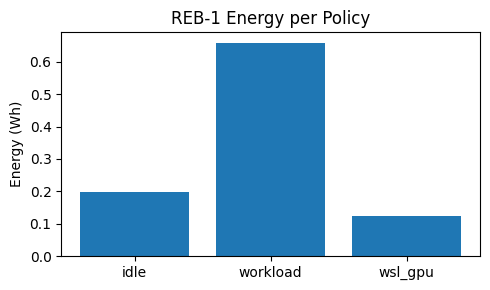

In [31]:
# Bar chart
fig1 = plt.figure(figsize=(5,3))
plt.bar(agg['policy_name'], agg['Wh'])
plt.ylabel('Energy (Wh)')
plt.title('REB-1 Energy per Policy')
png_out = 'fig_energy_bars.png'
plt.tight_layout()
plt.savefig(png_out, dpi=150)
png_out

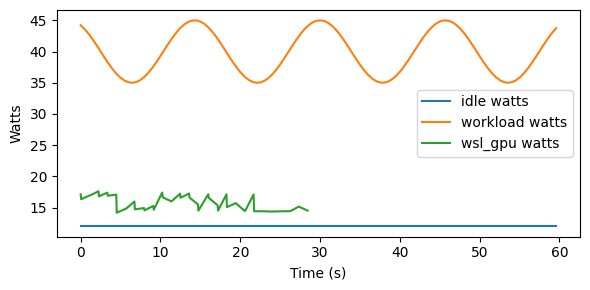

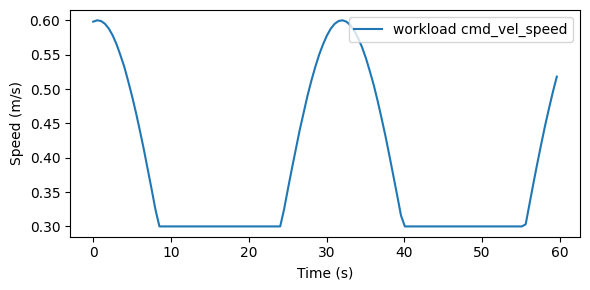

'reb1_demo.gif'

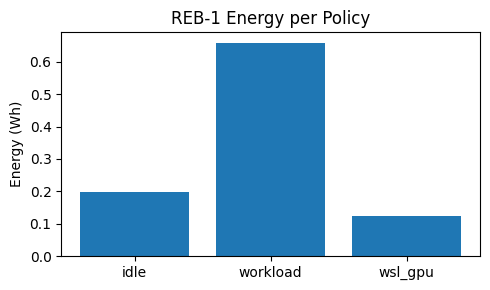

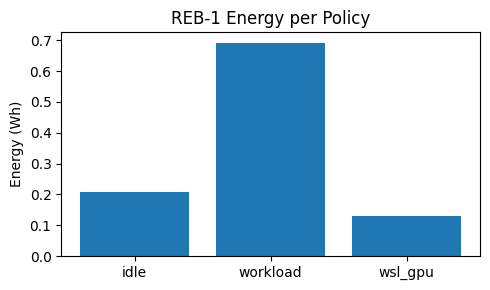

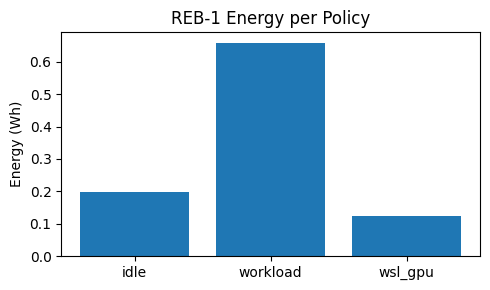

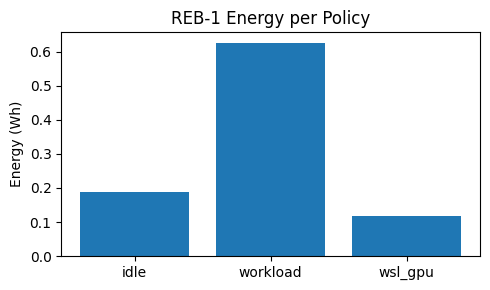

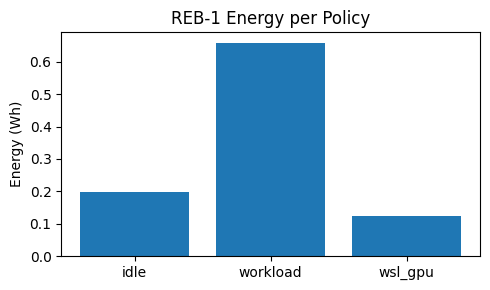

In [32]:
# Watts vs time overlay with optional cmd_vel
fig2 = plt.figure(figsize=(6,3))
for name, g in df.groupby('policy_name'):
    power = g['soc_power_w'] if g['soc_power_w'].notna().any() else g['gpu_power_w']
    plt.plot(g['time_s'], power, label=f'{name} watts')
plt.xlabel('Time (s)'); plt.ylabel('Watts'); plt.legend(loc='best'); plt.tight_layout()
plt.show()

# If cmd_vel_speed exists for any rows, overlay second plot
if df['cmd_vel_speed'].notna().any():
    fig3 = plt.figure(figsize=(6,3))
    for name, g in df.groupby('policy_name'):
        if g['cmd_vel_speed'].notna().any():
            plt.plot(g['time_s'], g['cmd_vel_speed'], label=f'{name} cmd_vel_speed')
    plt.xlabel('Time (s)'); plt.ylabel('Speed (m/s)'); plt.legend(loc='best'); plt.tight_layout(); plt.show()

# Tiny GIF (blink the bar chart)
frames = []
for scale in [1.0, 1.05, 1.0, 0.95, 1.0]:
    fig = plt.figure(figsize=(5,3))
    plt.bar(agg['policy_name'], agg['Wh']*scale)
    plt.ylabel('Energy (Wh)'); plt.title('REB-1 Energy per Policy')
    plt.tight_layout()
    tmp = f'_frame_{scale:.2f}.png'
    plt.savefig(tmp, dpi=150)
    frames.append(imageio.v2.imread(tmp))
imageio.mimsave('reb1_demo.gif', frames, duration=0.6)
'reb1_demo.gif'